# Microgrid sizing optimization: comparing Blackbox vs Algebraic approaches

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver
using NLopt # Blackbox nonlinear solvers

using Printf # pretty print results
using PyPlot

Precompiling Microgrids
  ✓ Microgrids
  1 dependency successfully precompiled in 2 seconds


## Problem setup

In [2]:
include("./example/Microgrid_Wind-Solar_data.jl");

Data definition for Microgrid with wind, solar, storage and generator...


In [3]:
"""Create a Microgrid project description of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind] in kW or kWh.

if x is omitted, x=[0.,0.,...] is used

Optionally, a few prices can be changed (keyword args)
"""
function create_microgrid(x;
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price)
    project = Project(lifetime, discount_rate, timestep, "€")
    # Split decision variables (converted MW → kW):
    power_rated_gen = x[1]
    energy_rated_sto = x[2]
    power_rated_pv = x[3]
    power_rated_wind = x[4]
    # Create components
    gen = DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen, lifetime_gen,
        load_ratio_min,
        replacement_price_ratio, salvage_price_ratio, fuel_unit)
    batt = Battery(energy_rated_sto,
        investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
        replacement_price_ratio, salvage_price_ratio)
    pv = Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv,
        replacement_price_ratio, salvage_price_ratio)
    windgen = WindPower(power_rated_wind, cf_wind,
        investment_price_wind, om_price_wind,
        lifetime_wind,
        replacement_price_ratio, salvage_price_ratio)
    mg = Microgrid(project, Pload, gen, batt, [pv, windgen])

    return mg
end

function create_microgrid(;
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price)
    x1 = [0., 0., 0., 0.]
    return create_microgrid(x1)
end

x_base = [1000. 1000. 1000. 1000.]
mg_base = create_microgrid(x_base)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1000.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399, 0.0375303795867147

In [4]:
"""capital recovery factor for discount rate `i` and duration `T`
CRF is such that Cann = NPC*CRF
"""
function CRF(i,T)
    if i != 0.0
        a = (1+i)^T
        return i*a/(a-1)
    else
        return 1/T
    end
end
CRF(0.05, 25)

0.0709524572992296

### Sizing bounds for each component

In [5]:
Pload_max = maximum(Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

xmax = [
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max
    ]

Max load power: 1707.0 kW

4-element Vector{Float64}:
  2048.4
 17070.0
 17070.0
  8535.0

## Blackbox microgrid sizing setup

### Objective function

- first bi-objective function x ↦ (lcoe, shedding rate)(x)
- then wrapped into a mono objective x ↦ J(x) by using a penalty for the excess of shedding rate
  - and match the interface expected by NLopt's optimizers

In [6]:
"""Multi-objective criterion for microgrid performance: lcoe, shedding rate.

Optionally, a few prices can be changed (keyword args)
"""
function obj_multi(x;
        relax,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price)
    mg = create_microgrid(x;
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price)
    # Launch simulation:
    traj, stats, costs = simulate(mg, relax)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate
end

obj_multi

In [7]:
obj_multi(x_base; relax=0.0), obj_multi(x_base; relax=1.0)

((0.20781653603718364, 0.00650933126708814), (0.1857600639716875, 0.00650933126708814))

### Wrapper of the blackbox optimization process

In [8]:
"""Optimize sizing of microgrid based on the `obj` function

Parameters:
- `x0`: initial sizing (for the algorithms which need them)
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
- `maxeval`: maximum allowed number of calls to the objective function,
  that is to the microgrid simulation
- `xtol_rel`: termination condition based on relative change of sizing, see NLopt doc.
- `srand`: random number generation seed (for algorithms which use some stochastic search)

Sizing maximum bounds are taken as the global variables `xmax`.
"""
function optim_mg(x0, shed_max; relax,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
        algo=:GN_CRS2_LM, maxeval=10_000, xtol_rel=1e-5, srand=1
    )

    """Mono-objective criterion: LCOE + penalty if shedding rate > `shed_max`
    with signature adapted to NLopt with `grad` as 2nd argument
    """
    function obj(x, grad, shed_max, w_shed_max=1e5)
        lcoe, shed_rate = obj_multi(x; relax=relax,
            investment_price_sto=investment_price_sto,
            investment_price_gen=investment_price_gen,
            fuel_price=fuel_price)
        over_shed = shed_rate - shed_max
        penalty = over_shed > 0.0 ? w_shed_max*over_shed : 0.0
        J = lcoe + penalty
    end
    
    nx = length(x0) # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = [0., 0., 1e-3, 0.] # 1e-3 instead of 0.0, because LCOE is NaN if ther is exactly zero generation
    opt.upper_bounds = xmax/1000
    opt.min_objective = (x_norm, grad) -> obj(x_norm*1000, grad, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = maxeval
    
    (fopt, x_norm_opt, ret) = optimize(opt, x0/1000)
    return x_norm_opt*1000, ret, opt.numevals
end

optim_mg

Starting point of blackbox optim: also derived from maximal load power

In [9]:
x0 = [1.0, 3.0, 3.0, 2.0] * Pload_max

4-element Vector{Float64}:
 1707.0
 5121.0
 5121.0
 3414.0

Test run of BB optim.

Case with 0.25 battery price (Grenoble workshop slides)

In [10]:
algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
shed_max = 0.00 # in [0,1]
maxeval=10000
srand=1
xopt, ret, numevals = optim_mg(x0, shed_max, relax=1.0, algo=algo, maxeval=maxeval, srand=srand)

algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
shed_max = 0.00 # in [0,1]
maxeval=10000
srand=1
relax=0.0 # no relaxation
relax=1.0 # full relaxation
@time xbb, ret, numevals = optim_mg(x0, shed_max; relax=relax,
                                     algo=algo, maxeval=maxeval, srand=srand,
                                     investment_price_sto=investment_price_sto*0.25,
                                     investment_price_gen=investment_price_gen,
                                     fuel_price=fuel_price)

@printf("%s algo: %s after %d iterations (relax=%.1f). \nx*=", algo, ret, numevals, relax)
println(round.(xbb; digits=1)) # kW
lcoe_bb, shed_rate_bb = obj_multi(xbb; relax=relax,
                                 investment_price_sto=investment_price_sto*0.25,
                                 investment_price_gen=investment_price_gen,
                                 fuel_price=fuel_price)
println("LCOE*: ", lcoe_bb)
println("shed*: ", shed_rate_bb)

  0.892592 seconds (379.51 k allocations: 2.010 GiB, 4.09% gc time, 1.48% compilation time)
GN_CRS2_LM algo: XTOL_REACHED after 2549 iterations (relax=1.0). 
x*=[1577.2, 4766.5, 1969.6, 1249.7]
LCOE*: 0.17232666449068842
shed*: 0.0


In [11]:
round.(xbb; digits=1)

4-element Vector{Float64}:
 1577.2
 4766.5
 1969.6
 1249.7

Detailed performance statistics of blackbox optim:

In [12]:
mgopt_bb = create_microgrid(xbb;
        investment_price_sto=investment_price_sto*0.25,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price);
mgopt_bb.generator.power_rated

1577.1812661847691

In [13]:
traj_bb, stats_bb, costs_bb = simulate(mgopt_bb, relax)
traj_bb, stats_bb_norelax, costs_bb_norelax = simulate(mgopt_bb, 0.0)
stats_bb.renew_rate

0.7845367569966673

## All-in-one algebraic approach with JuMP

### basic time series reduction

In [14]:
"""reduce the year time series `x` to `ndays` ≤ 365
sr=24: data sampling rate / day. 24 means hourly time step.

The method is *basic*:
it samples `ndays` days evenly spaced by (365 ÷ `ndays`) days

with ndays=365, returns the orinal series
"""
function ts_reduction(x, ndays, sr=24)
    out = zeros(ndays*sr)
    @assert ndays<=365
    Δdays = 365 ÷ ndays
    for i in 1:ndays
        offset_in = (i-1)*Δdays*sr
        offset_out = (i-1)*sr
        out[offset_out+1:offset_out+sr] = x[offset_in+1:offset_in+sr]
    end
    return out
end

ts_reduction

Generator of piecewise linear approximation to the “annualized size” function of size $x$ and usage $u$:

$$x_{ann}(x,u) = x.CRF(T(x, u))$$

with lifetime varying with size and usage as $T=x/u$.

In [15]:
"""intercept and slope of tangent to function g:z → 1/(1-e^(-1/z))  at point `z0`

Usage: with gi, g1 = g_asym(z0),
then g(z) ~ gi + g1*z around z0
gi: intercept at z=0
g1: slope
"""
function g_tan(z0)
    z=z0
    emiz = exp(-1/z)
    g = 1/(1-emiz) # g(z)
    g1 = emiz/(z^2*(1-emiz)^2) # g'(z)
    ginter = g - g1*z
    return ginter, g1
end
g_tan(1e-3), g_tan(1/2), g_tan(1e3)

((1.0, 0.0), (0.7944868122665105, 0.7240616609663105), (0.500166666631003, 0.9999999166667313))

In [16]:
[
    (1.0, 0.); # ginter, g1 for each z0
    [(g_tan(z0)[1], g_tan(z0)[2]) for z0 in [.1,0.5,1e3]];
    (0.5, 1.0)
]

5-element Vector{Tuple{Float64, Float64}}:
 (1.0, 0.0)
 (0.9995913614675049, 0.004540405235047541)
 (0.7944868122665105, 0.7240616609663105)
 (0.500166666631003, 0.9999999166667313)
 (0.5, 1.0)

In [17]:
"""Piecewise linear approximation of “annualized size” function of size and usage

Parameters:
- Xann, X, U: JuMP variables or expressions
- discount_rate: Real number in [0,1] (negative discount not implemented)
- z_tan: list z values where to use tangents of g(z).

Recommended values:
- z_tan = [0.5]: 5% CRF underestimation error
- z_tan = [0.28, 0.5, 1.0]: 1.6% error
- z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]: 0.23% error

Tangents at z=0 and z->infty are also added, so no need to add these.
"""
function cons_Xann_usage!(model, Xann, X, U, discount_rate, z_tan=[0.28, 0.5, 1.0])
    r = discount_rate/log(1+discount_rate)
    @constraint(model, Xann >= X*discount_rate)
    @constraint(model, Xann >= X*discount_rate*0.5 + U*r)
    tan_params = [ # ginter, g1 for each z0 in z_tan, including z=0 and +infty
        (1.0, 0.); 
        [(g_tan(z0)[1], g_tan(z0)[2]) for z0 in z_tan];
        (0.5, 1.0)
    ]
    ntan = length(tan_params)
    cvec = @constraint(model, [k=1:ntan],
        Xann >= X*discount_rate*tan_params[k][1]
              + U*r*tan_params[k][2]
    )
    cname = "c_" * name(Xann) *"_"* name(X) *"_"* name(U)
    set_name.(cvec, [cname * "[$k]" for k=1:ntan])
    return cvec
end

cons_Xann_usage!

Test:

In [35]:
mtest = Model()
@variable(mtest, Xann)
@variable(mtest, X)
@variable(mtest, U)
cons_Xann_usage!(mtest, Xann, X, U, 0.05)

5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 c_Xann_X_U[1] : Xann - 0.05 X ≥ 0
 c_Xann_X_U[2] : Xann - 0.04613111050299047 X - 0.3890816707882075 U ≥ 0
 c_Xann_X_U[3] : Xann - 0.039724340613325526 X - 0.7420160121329831 U ≥ 0
 c_Xann_X_U[4] : Xann - 0.03306515563307671 X - 0.9435032755891112 U ≥ 0
 c_Xann_X_U[5] : Xann - 0.025 X - 1.0247967157143927 U ≥ 0

### Algebraic model definition

→ this should be split in a package?

In [118]:
"""Setup microgrid sizing optimization model using JuMP

Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `ndays=365`: data reduction
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max

Returns:
- mg: base microgrid
- JuMP model
- LCOE expression
"""
function setup_optim_mg_jump(shed_max, optimizer;
        ndays=365,
        fixed_lifetimes=false,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
    )

    # base Microgrid with 1kW(h) ratings
    mg = create_microgrid([1., 1., 1., 1.];
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price)
    
    dt = mg.project.timestep
    CRFproj(T) = CRF(mg.project.discount_rate, T) 

    K = ndays*24 # h
    ts_reduction_ndays(x) = ts_reduction(x, ndays)

    Pload = mg.load |> ts_reduction_ndays;
    Eload_desired = sum(Pload)*dt*365/ndays

    # (works because the rated power in mg are set to 1 kW)
    cf_pv   = production(mg.nondispatchables[1]) |> ts_reduction_ndays
    cf_wind = production(mg.nondispatchables[2]) |> ts_reduction_ndays;

    ### JuMP model ###
    model = Model(optimizer)
    set_silent(model)

    ##  Sizing variables
    @variable(model, 0 <= power_rated_gen <= power_rated_gen_max)
    @variable(model, 0 <= energy_rated_sto <= energy_rated_sto_max)
    @variable(model, 0 <= power_rated_pv <= power_rated_pv_max)
    @variable(model, 0 <= power_rated_wind <= power_rated_wind_max)

    ## Power flows for each component
    
    # Non dispatchable sources (renewables)
    @variable(model, pv_potential[1:K])
    @constraint(model, pv_potential .== power_rated_pv*cf_pv)
    @variable(model, wind_potential[1:K])
    @constraint(model, wind_potential .== power_rated_wind*cf_wind);
    renew_potential = pv_potential + wind_potential

    # desired net load (before spillage of excess renewables and load shedding)
    @variable(model, Pnl[1:K])
    @constraint(model, Pnl .== Pload .- renew_potential)

    @variable(model, Pspill[1:K] >= 0)
    @variable(model, Pshed[1:K] >= 0)
    # Dispatchable generator
    @variable(model, Pgen[1:K] >= 0)
    @constraint(model, Pgen .<= power_rated_gen)

    ## Energy storage
    # Charge and discharge power
    @variable(model, Psto_cha[1:K] >= 0)
    @variable(model, Psto_dis[1:K] >= 0)
    # Energy
    @variable(model, Esto[1:K+1])
    @constraint(model, Esto .<= energy_rated_sto) # SoCmax = 1 implicitly
    @constraint(model, Esto .>= mg.storage.SoC_min*energy_rated_sto) # often 0
    # Power constraints
    @constraint(model, Psto_cha .<= mg.storage.charge_rate    * energy_rated_sto)
    # Evolution of the State of Energy,
    # , with piecewise linear in P loss term (aka constant efficiency model)
    a = mg.storage.loss_factor
    @constraint(model,
        stodyn[k=1:K],
        Esto[k+1] == Esto[k] + (Psto_cha[k] - Psto_dis[k] - a*(Psto_cha[k]+Psto_dis[k]))*dt
    )
    # Storage cyclicity
    @constraint(model, Esto[K+1] == Esto[1])
    # not implemented: force initial SoC # TODO: activate to make it comparable with BB
    #@constraint(model, Esto[1] == mg.storage.SoC_ini * energy_rated_sto)
    
    ## Power balance
    @constraint(model, balance,  Pgen + (Psto_dis - Psto_cha) - Pspill .== Pnl - Pshed)

    if shed_max == 0.0
        fix.(Pshed, 0.0; force=true);
    else
        Eshed = sum(Pshed)*dt * 365/ndays
        @constraint(model, Eshed <= Eload_desired*shed_max)
    end

    ### Costs
    z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0] # for Xann or CRF PWL approx
    #z_tan = [0.5] # simpler PWL, as used in Grenoble slides
    # Generator costs
    Egen = sum(Pgen)*dt * 365/ndays

    if fixed_lifetimes
        println("Fixed lifetime hypothesis for generator")
        # assumed generator operation hours:
        gen_hours = 3000. # in 0 – 8760
        gen_lifetime = mg.generator.lifetime_hours / gen_hours # years
        println("fixed generator lifetime: ", gen_lifetime, " y, i.e. ", gen_hours, " h/y")
        Pgen_rated_ann = power_rated_gen * CRFproj(gen_lifetime)
    else
        hours_factor = 1.0 # adjust the penalty on linearized hours
        println("Usage-dependant lifetime hypothesis for generator (hours_factor=", hours_factor,")")
        @variable(model, Pgen_rated_ann >= 0) # annualized size
        @variable(model, 0 <= Ugen)
        @constraint(model, Ugen == Egen*hours_factor/mg.generator.lifetime_hours); # kW/y
        cpwl_gen = cons_Xann_usage!(model,
            Pgen_rated_ann, power_rated_gen, Ugen,
            discount_rate, z_tan)
    end   
    Cgen_om = fixed_lifetimes ? 
        mg.generator.om_price_hours * gen_hours * power_rated_gen :
        mg.generator.om_price_hours * hours_factor * Egen

    Cgen = mg.generator.investment_price * Pgen_rated_ann +
           Cgen_om +
           mg.generator.fuel_price * mg.generator.fuel_slope * Egen;# $/y
    
    # Battery costs
    @variable(model, Esto_rated_ann >= 0) # annualized size
    Csto = mg.storage.investment_price * Esto_rated_ann +
           mg.storage.om_price * energy_rated_sto
    # A) Effect of calendar lifetime:
    CRFsto_cal = CRFproj(mg.storage.lifetime_calendar)
    @constraint(model, Esto_rated_ann >= energy_rated_sto*CRFsto_cal)
    # B) Effect of cycling
    if ~fixed_lifetimes
        @variable(model, 0 <= Usto)
        E_through_sto = (sum(Psto_cha) + sum(Psto_dis))*dt
        @constraint(model, Usto == E_through_sto/(2*mg.storage.lifetime_cycles))
        cpwl_sto = cons_Xann_usage!(model,
            Esto_rated_ann, energy_rated_sto, Usto,
            discount_rate, z_tan)
    end

    # Wind and solar costs
    pv = mg.nondispatchables[1]
    Cpv = pv.investment_price * power_rated_pv * CRFproj(pv.lifetime) + 
          pv.om_price * power_rated_pv
    wind = mg.nondispatchables[2]
    Cwind = wind.investment_price * power_rated_wind * CRFproj(wind.lifetime) + 
        wind.om_price * power_rated_wind

    # Total cost
    Cann = Cgen + Csto +  Cpv + Cwind
    decrease = collect(1 .- (1:K)/K) # sequence from 0.99x to 0
    #penal = 1e-5*sum((Psto_cha-Psto_dis).*decrease)*dt
    penal = 1e-5*sum(Pgen.*decrease)*dt
    @objective(model, Min, Cann+penal)

    LCOE = Cann/Eload_desired
    return mg, model, LCOE
end

setup_optim_mg_jump

Test setup function to get JuMP model.

In [91]:
mg_base, model, LCOE_expr = setup_optim_mg_jump(shed_max, HiGHS.Optimizer)
model

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)


A JuMP Model
Minimization problem with:
Variables: 78849
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 43803 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 8786 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 26281 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 35048 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: Esto, Esto_rated_ann, Pgen, Pgen_rated_ann, Pnl, Pshed, Pspill, Psto_cha, Psto_dis, Ugen, Usto, balance, energy_rated_sto, power_rated_gen, power_rated_pv, power_rated_wind, pv_potential, stodyn, wind_potential

Wrapper of algebraic optimization (includes diagnostics)

In [119]:
"""Optimize sizing of microgrid optimization using JuMP

Parameters: see `setup_optim_mg_jump`
"""
function optim_mg_jump(shed_max, optimizer;
        ndays=365,
        fixed_lifetimes=false,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
        model_custom=nothing
    )

    # Create model
    mg_base, model, LCOE = setup_optim_mg_jump(shed_max, optimizer;
        ndays=ndays,
        fixed_lifetimes=fixed_lifetimes,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
    )

    if model_custom !== nothing
        model_custom(model)
    end
    
    # Optimize
    @time JuMP.optimize!(model)

    # Extract results
    LCOE_opt = value(LCOE)
    xopt = value.([
        model[:power_rated_gen]
        model[:energy_rated_sto]
        model[:power_rated_pv]
        model[:power_rated_wind]
    ])
    
    Tgen = value(model[:power_rated_gen]/model[:Ugen])
    CRFgen_relax = value(model[:Pgen_rated_ann]/model[:power_rated_gen])
    Tcyc = value(model[:energy_rated_sto]/model[:Usto])
    Tsto = min(Tcyc, mg_base.storage.lifetime_calendar)
    CRFsto_relax = value(model[:Esto_rated_ann]/model[:energy_rated_sto])

    # Diagnostics about annualized sized relaxation
    # i.e. PWL approx of CRF
    CRFproj(T) = CRF(mg_base.project.discount_rate, T)

    diagnostics = (
        # Generator
        Ugen = value(model[:Ugen]),
        Tgen = Tgen,
        CRFgen = CRFproj(Tgen),
        CRFgen_relax = CRFgen_relax,
        CRFgen_relax_rel = CRFgen_relax/CRFproj(Tgen),
        # Storage
        Usto = value(model[:Usto]),
        Tcyc = Tcyc,
        Tsto = Tsto,
        CRFsto = CRFproj(Tsto),
        CRFsto_relax = CRFsto_relax,
        CRFsto_relax_rel = CRFsto_relax/CRFproj(Tsto)
    )

    traj = (
        Pgen = value.(model[:Pgen]),
        Psto = value.(model[:Psto_dis] - model[:Psto_cha]),
        Esto = value.(model[:Esto]),
        Pshed = value.(model[:Pshed])
    )
    return xopt, LCOE_opt, diagnostics, traj
    
end

optim_mg_jump

Test Algebraic optim
- Case with 0.25 battery price (Grenoble workshop slides)

In [120]:
xalg, lcoe_alg, diagnostics, traj_alg = optim_mg_jump(shed_max, HiGHS.Optimizer;
    #ndays=10,
    investment_price_sto=investment_price_sto*0.25,
    investment_price_gen=investment_price_gen,
    fuel_price=fuel_price
)
lcoe_alg

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)
 18.256274 seconds (885.59 k allocations: 91.343 MiB, 0.19% gc time)


0.1715937186003287

(without Psto_cha penalty: 0.171 593 718 60032874, i.e. negigible difference for penal 1e-5, but not with 1e-4)

with z_tan = [.5], slightly smaller LCOE:

0.1714263650686344
```x=
 1154.4
 5131.0
 2037.0
 1239.9
```

In [121]:
round.(xalg; digits=1)

4-element Vector{Float64}:
 1151.3
 5227.9
 2055.0
 1234.5

without Psto_cha penalty: identical (after rounding)

 1151.3
 5227.9
 2055.0
 1234.5

with z_tan = [0.5]
```
Tgen = 12.157818761162602
CRFgen = 0.11174838318777107
CRFgen_relax = 0.1092911656972583
CRFgen_relax_rel = 0.9780111584578016
```

now with z_tan having 8 points (10 tangents): `CRFgen_relax_rel = 0.9999978736992846`

In [43]:
diagnostics

(Ugen = 94.53828693656102, Tgen = 12.177752623295897, CRFgen = 0.11161438827074813, CRFgen_relax = 0.1116141509449945, CRFgen_relax_rel = 0.9999978736992846, Usto = 255.87797815604043, Tcyc = 20.431091709053458, Tsto = 15.0, CRFsto = 0.09634228760924432, CRFsto_relax = 0.09634228760924432, CRFsto_relax_rel = 1.0)

## BB-Algebraic cost validation

to verify that the Algebraic JuMP model yields the same result as BB for the same sizing and energy dispatch

In [44]:
"""Force microgrid sizing by constraining energy storage trajectory"""
function force_sizing!(model, Esto_traj)
    # Check that storage trajectory is fine
    @assert length(Esto_traj) == length(model[:Esto])
    @assert Esto_traj[1] - Esto_traj[end] == 0.0 "Storage trajectory should be cyclic"
    # Fix storage trajectory:
    @constraint(model, model[:Esto] .== Esto_traj);
end

force_sizing!

Test BB forcing

Case with 0.25 battery price (Grenoble workshop slides), forced to BB

In [45]:
Esto_traj = traj_bb.Ebatt # storage traj to be forced
xfbb, lcoe_fbb, diagnostics_fbb = optim_mg_jump(shed_max, HiGHS.Optimizer;
    investment_price_sto=investment_price_sto*0.25,
    investment_price_gen=investment_price_gen,
    fuel_price=fuel_price,
    model_custom=model->force_sizing!(model, Esto_traj)
)

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)
  1.970454 seconds (973.20 k allocations: 96.323 MiB, 5.22% gc time)


([1577.181004069868, 4766.513889783261, 1969.597785206941, 1249.707515749773], 0.17230739290314268, (Ugen = 97.31726310796489, Tgen = 16.20659021534674, CRFgen = 0.09149417924294653, CRFgen_relax = 0.09128722566144742, CRFgen_relax_rel = 0.9977380683316522, Usto = 237.23212090669188, Tcyc = 20.09219439410579, Tsto = 15.0, CRFsto = 0.09634228760924432, CRFsto_relax = 0.09634228760924432, CRFsto_relax_rel = 1.0))

Tgen = 16.20659021534674, CRFgen = 0.09149417924294653, CRFgen_relax = 0.09128722566144742, CRFgen_relax_rel = 0.9977380683316522

Sizing comparison: the forcing works

In [47]:
round.([xbb xfbb]; digits=2)

4×2 Matrix{Float64}:
 1577.18  1577.18
 4766.51  4766.51
 1969.6   1969.6
 1249.71  1249.71

LCOE comparison: absolute and relative to BB LCOE

- Alebraic model yields a cost which is 99.989% of BB cost (for same sizing and dispatch) with 10 tangents. Was 99.82% with 3 tangents

with z_tan = [0.5]

```
3×2 Matrix{Float64}:
 172.023   99.8238
 172.327  100.0
 171.426   99.4776
```

In [48]:
v1 = [lcoe_fbb, lcoe_bb, lcoe_alg]*1000 # €/MWh
v2 = [lcoe_fbb, lcoe_bb, lcoe_alg]/lcoe_bb*100
[v1 v2]

3×2 Matrix{Float64}:
 172.307   99.9888
 172.327  100.0
 171.594   99.5747

## BB-Algebraic comparison

In [54]:
"""Optimize sizing of microgrid using JuMP

Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `ndays=365`: data reduction
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max
"""
function optim_mg_both(shed_max;
        jump_optimizer,
        bb_algo=:GN_CRS2_LM, bb_srand=1,

        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price
    )

    jump_optimizer=HiGHS.Optimizer

    xalg, lcoe_alg, diagnostics = optim_mg_jump(shed_max, jump_optimizer;
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price
    )

    relax=1.0
    maxeval=10_000
    xbb, ret, numevals = optim_mg(x0, shed_max; relax=relax,
                                     algo=bb_algo, maxeval=maxeval, srand=srand,
                                     investment_price_sto=investment_price_sto,
                                     investment_price_gen=investment_price_gen,
                                     fuel_price=fuel_price)

    # Check performances
    lcoe_bb, shed_rate_opt_bb = obj_multi(xbb; relax=relax,
                                             investment_price_sto=investment_price_sto,
                                             investment_price_gen=investment_price_gen,
                                             fuel_price=fuel_price)
    mg_alg = create_microgrid(xalg;
                investment_price_sto=investment_price_sto,
                investment_price_gen=investment_price_gen,
                fuel_price=fuel_price)
    # Alg sizing evaluated with simple Rule-based EM:
    traj_alg_bb, stats_alg_bb, costs_alg_bb = simulate(mg_alg, relax)

    # TODO: pass bb sizing through Alg model to check model quasi equivalence...
    
    return (
        xbb=xbb, xalg=xalg,
        lcoe_bb=lcoe_bb, lcoe_alg=lcoe_alg, lcoe_alg_bb=costs_alg_bb.lcoe,
        sr_alg_bb = stats_alg_bb.shed_rate,
        mg_alg=mg_alg
    )
end

optim_mg_both

case with 0.25 battery price (Grenoble workshop slides)

In [55]:
shed_max = 0.0
res = optim_mg_both(shed_max;
    jump_optimizer=HiGHS.Optimizer,
    investment_price_sto=investment_price_sto*0.25,
    investment_price_gen=investment_price_gen,
    fuel_price=fuel_price
)

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)
 21.869627 seconds (885.59 k allocations: 91.343 MiB, 0.15% gc time)


(xbb = [1577.1812661847691, 4766.513889783261, 1969.5977852069411, 1249.7075157497723], xalg = [1151.2638717436062, 5227.866438033239, 2054.9834379336817, 1234.532781952971], lcoe_bb = 0.17232666449068842, lcoe_alg = 0.17159371860032874, lcoe_alg_bb = 0.1712989085488984, sr_alg_bb = 0.002347267260139537, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1151.2638717436062, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(5227.866438033239, 87.5, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(2054.9834379336817, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1234.532781952

In [56]:
round.(res.xalg)

4-element Vector{Float64}:
 1151.0
 5228.0
 2055.0
 1235.0

In [58]:
res.lcoe_bb, res.lcoe_alg, res.lcoe_alg_bb

(0.17232666449068842, 0.17159371860032874, 0.1712989085488984)

In [60]:
res.sr_alg_bb*100 # %

0.23472672601395372

trying other more crazy price configurations... doesn't yield more striking results

In [32]:
res2 = optim_mg_both(0.0;
    jump_optimizer=HiGHS.Optimizer,
    investment_price_sto=investment_price_sto*0.01,
    investment_price_gen=investment_price_gen*2,
    fuel_price=fuel_price*0.375
)
res2

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)
 20.412364 seconds (885.59 k allocations: 91.343 MiB, 1.61% gc time)


(xbb = [1593.8905809884252, 2000.6965465866951, 1127.9440826494279, 1022.2856262628892], xalg = [1270.0916283545673, 2310.4687116941323, 1196.3080040308919, 1001.6311610278491], lcoe_bb = 0.13715037574389147, lcoe_alg = 0.13605224304689353, sr_alg_bb = 0.0011607945943899547, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1270.0916283545673, 0.0, 0.24, 0.375, 800.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(2310.4687116941323, 3.5, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1196.3080040308919, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1001.6311610278491, [0.03184904690521816, 

High fuel price: yields an even smaller LP generator 

In [33]:
res3 = optim_mg_both(0.0;
    jump_optimizer=HiGHS.Optimizer,
    investment_price_sto=investment_price_sto,
    investment_price_gen=investment_price_gen,
    fuel_price=fuel_price*4.0
)

Usage-dependant lifetime hypothesis for generator (hours_factor=1.0)
  8.318046 seconds (885.59 k allocations: 91.343 MiB, 0.34% gc time)


(xbb = [1546.2471658308143, 7603.588342335612, 4105.686271969297, 1670.947503682742], xalg = [974.3822257332465, 7765.259432830297, 4162.141089686538, 1653.4268709397613], lcoe_bb = 0.2891352534760916, lcoe_alg = 0.2879897837549454, sr_alg_bb = 0.0036700053827238054, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(974.3822257332465, 0.0, 0.24, 4.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(7765.259432830297, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(4162.141089686538, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1653.4268709397613, [0.03184904690521816, 0.110493264

In [34]:
res3.xalg

4-element Vector{Float64}:
  974.3822257332465
 7765.259432830297
 4162.141089686538
 1653.4268709397613

### Plots

In [61]:
traj_alg_bb, stats_alg_bb, costs_alg_bb = simulate(res.mg_alg, 1.0)

(OperationTraj{Float64}([1151.2638717436062, 1151.2638717436062, 910.348334161291, 597.5956965960357, 268.8713868957294, -10.762008501818627, -150.6099419706038, -129.8520995879535, -72.4678878113723, -14.784034766501463  …  537.6978620078164, 854.7820792927895, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062, 1151.2638717436062], [262.4174357779441, 43.32857070682803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 229.54662825125865, 182.0736192155814, 270.8496977365303, 389.8880944637515, 363.40364433745594, 273.91675418523755, 335.40364433745594, 286.3701103373139], [39.31869247844964, 136.40755754956572, 303.65166583870905, 548.4043034039643, 809.1286131042706, 1045.7620085018186, 1182.6099419706038, 1201.8520995879535, 1214.4678878113723, 1222.7840347665015  …  941.3021379921836, 653.2179207072105, 29.189500005135294, 36.6625090408125, 44.88643051986347, 45.848033792642454, 46.33248391

In [152]:
function plot_oper_traj(td, Pload, Pgen, Pren, Pshed, Ebatt)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,2.5), sharex=true)
    ax1.plot(td, Pload, label="load")
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Pren, "tab:green", label="renew")
    ax1.plot(td, Pshed, "tab:pink", label="shed")
    
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend()
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    fig.tight_layout()
    return fig, (ax1, ax2)
end

plot_oper_traj (generic function with 2 methods)

In [164]:
"""plot trajectories to illustrative non anticipativity"""
function plot_oper_traj2(td, Pload, Pgen, Pren, Psto, Pshed, Ebatt)
    Pnl_req = Pload - Pren
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,2.5), sharex=true)
    ax1.plot(td, Pnl_req, label="net load", lw=3, alpha=0.5)
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Psto, "tab:green", label="sto")

    #y1 = Pnl_req-Pshed
    #y2 = Pnl_req
    #println(size(td), size(y1), size(y2))
    #ax1.fill_between(td, y1, y2, "tab:pink", label="shed")
    ax1.plot(td, Pshed, "tab:pink", label="shed")
    
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend(ncol=4)
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    fig.tight_layout()
    return fig, (ax1, ax2)
end

plot_oper_traj2

In [165]:
#pygui(true) # open interactive plot window
pygui(false) # display image in notebook

false

In [166]:
K = 365*24
td = collect((0:K-1)/24); # time in days

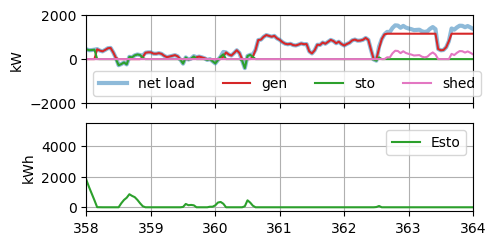

In [175]:
fig, (ax1, ax2) = plot_oper_traj2(td, mg_base.load,
    traj_alg_bb.Pgen,
    traj_alg_bb.Prenew_pot,
    traj_alg_bb.Pbatt,
    traj_alg_bb.power_shedding,
    traj_alg_bb.Ebatt,
)
ax1.set_ylim(-2000, 2000)
ax1.set_xlim(358, 364); # winter, end  of year, low wind -> shedding with Algebraic generator
fig.savefig("traj_alg_bb_358-364.png", dpi=250, bbox_inches="tight")

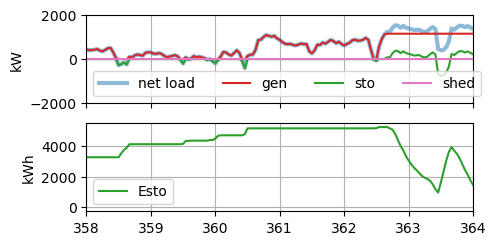

In [174]:
fig, (ax1, ax2) = plot_oper_traj2(td, mg_base.load,
    traj_alg.Pgen,
    traj_alg_bb.Prenew_pot,
    traj_alg.Psto,
    traj_alg.Pshed,
    traj_alg.Esto,
)
ax1.set_ylim(-2000, 2000)
ax1.set_xlim(358, 364); # winter, end  of year, low wind -> shedding with Algebraic generator
fig.savefig("traj_alg_358-364.png", dpi=250, bbox_inches="tight")

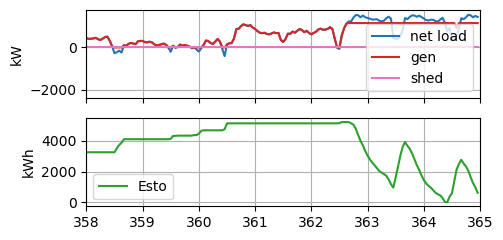

In [74]:
fig, (ax1, ax2) = plot_oper_traj2(td, mg_base.load,
    traj_alg.Pgen,
    traj_alg_bb.Prenew_pot,
    traj_alg.Pshed,
    traj_alg.Esto,
)

ax1.set_xlim(358, 36); # winter, end  of year, low wind -> shedding with Algebraic generator